In [147]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import os
import re
import sys
import pandas as pd
import numpy as np
import random
from functools import partial
from pathlib import Path
from pprint import pprint
import copy
import seaborn as sns

import torch
import yaml
from torch.utils.data import DataLoader
from captum.attr import LRP 
from tqdm.std import tqdm

# for the LRP
import torch.nn as nn
from captum.attr import InputXGradient, LRP, IntegratedGradients
from captum.attr._utils.lrp_rules import (
    Alpha1_Beta0_Rule,
    EpsilonRule,
    GammaRule,
    IdentityRule,
)

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.preprocessing import RobustScaler
import vis_pkg
import helper_pkg
import json
import cartopy as cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cmocean
plt.rcParams["font.family"] = "Arial"
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.3
mpl.rcParams.update({'hatch.color': 'gray'})

# Terrible hack to make sure Jupyter notebooks (which use different PYTHONPATH
# for some reason!) actually sees src/ directory so we can import from there.
os.chdir("/Users/jgra0019/Documents/codes/ml4szeq/ml4szeq")
print(f"--- Current working directory: {os.getcwd()}")
if not any([re.search("src$", path) for path in sys.path]):
    sys.path.append(str(Path.cwd() / "src"))

import default
from dataset import DFDataset
from fit import Fit
from utils import (convert_hyperparam_config_to_values, get_config,
                   get_full_hyperparam_config, load_data)
from model import *
from predictor import predictions

# %% GETTING HYPER-PARAMETERS
config_override_file = get_config("PARAMETER_YAML_FILE", None)
hyperparam_config = get_full_hyperparam_config(config_override_file=config_override_file)
print(
    "--- Hyperparameters/metadata set as follows (may be altered later if using EXISTING wandb sweep):"
)
pprint(hyperparam_config)


--- Current working directory: /Users/jgra0019/Documents/codes/ml4szeq/ml4szeq
--- Reading from default.yml to build up initial hyperparameters dictionary...
--- Checking to see if we want to override default hyperparameters with new file...
--- Override file found! Updating with hyperparameters from default.yml...
--- Hyperparameters/metadata set as follows (may be altered later if using EXISTING wandb sweep):
{'entity': 'jcgraciosa',
 'method': 'grid',
 'parameters': {'activation_function': {'value': 'relu'},
                'batch_normalisation': {'value': False},
                'batch_size': {'value': 16},
                'cat_scaling': {'value': 1},
                'categorical_output': {'value': True},
                'dataset': {'value': 'lin_samp_50'},
                'dropout': {'value': 0.2},
                'embeddings': {'value': 0},
                'epochs': {'value': 120},
                'exclude_file': {'value': 'xyz.csv'},
                'hidden_layers': {'value': [5

## Mapping code
All data are used in training, portion is reserved for testing

In [148]:
''' settings to define '''

tr_all_region_N = 4
sep_dist = 100
mod_rank = 1 # rank of the model - valid numbers are 1, 2, 3, 4, 5

# for the model_list, list the part with hyperparameter list
num_class = 3
num_model = 1
device = "cpu"

# other important config
tr_half_use = None
do_tr_all_region = True

#scenario = 4 # 3 - with RAND_CTRL; 4 - without RAND_CTRL
do_stnd = True  # perform standardization of the relevance values or not
use_tp = True   # use True positive 
apply_thresh = False    # set to True if we apply threshold to heatmap values

thresh_val = 0

model_dir = f"/Users/jgra0019/Documents/codes/ml4szeq/ml4szeq/out/models/all-used-training-wbal-cls{num_class}"
if num_class == 2:
    hparam_file = f"{model_dir}/model{tr_all_region_N}/model{tr_all_region_N}-sep{sep_dist}-top10.json"
elif num_class == 3:
    hparam_file = f"{model_dir}/model{tr_all_region_N}/model{tr_all_region_N}-sep{sep_dist}-cls{num_class}-top10.json"
hparam_file = Path(hparam_file)

with open(hparam_file) as json_data_file:
    hparam = json.load(json_data_file)

hparam_sset = hparam

hparam_sset = hparam_sset[str(mod_rank)]

epoch_use = hparam_sset["epoch_use"]
folder_use = hparam_sset["folder"]

# xai parameters 
algo_use = "lrp_def" # use default

# FIXME: set these correctly
out_dir = Path(f"{model_dir}/xai-map-model{tr_all_region_N}-cls{num_class}")
model_dir = Path(f"{model_dir}/model{tr_all_region_N}")

print(f"Model directory: {model_dir}")
print(f"Output directory: {out_dir}")

out_dir.mkdir(parents=True, exist_ok=True) 

# plotting limits - only for the sep in [50, 100]
if num_class == 2:
    if sep_dist == 50:
        vminmax = 3
        histminmax = 3.3
        tickmarks = [-3, -2, -1, 0, 1, 2, 3]
        ymax = 15
    elif sep_dist == 100:
        vminmax = 3
        histminmax = 5.6
        tickmarks = [-3, -2, -1, 0, 1, 2, 3]
        ymax = 15
elif num_class == 3:
    if sep_dist == 50:
        vminmax = 3 
        histminmax = 5
        tickmarks = [-3, -2, -1, 0, 1, 2, 3]
        ymax = 15
    elif sep_dist == 100:
        vminmax = 3 
        histminmax = 5
        tickmarks = [-3, -2, -1, 0, 1, 2, 3]
        ymax = 15

tickmarks = np.array(tickmarks)

Model directory: /Users/jgra0019/Documents/codes/ml4szeq/ml4szeq/out/models/all-used-training-wbal-cls3/model4
Output directory: /Users/jgra0019/Documents/codes/ml4szeq/ml4szeq/out/models/all-used-training-wbal-cls3/xai-map-model4-cls3


### A. Preparations for the map and function declarations

In [149]:
''' Function declarations '''

# arrange features properly
def arrange_features(feat_list):
    phys_state_list = ["CRD_UP", "CRS_UP", "CRM_UP",
                   "INV_UP", "DLT_UP", "SED", "SRO", "IRO", "LRO"
                   ]
    dyna_list = ["FRE_DG", "FRE_UP", "BGR_DG",  
                "EGO_UP", 
                "EGO_L_UP", 
                "EGO_SL_UP",  
                "EGO_UM_UP",
                "EGR_DG", 
                "EGR_UP", 
                "EGR_BG_UP",
                "DXT", "FDM", "SDM"]
    kine_list = ["V_UP", "V_TN", "AGE"]
    
    new_feat_list = []

    # loop through all phys state list
    for phys_state in phys_state_list:
        for feat in feat_list:
            if (phys_state in feat) and (feat not in new_feat_list):
                new_feat_list.append(feat)
            
    # loop through all dyna list
    for dyna in dyna_list:
        for feat in feat_list:
            if (dyna in feat) and (feat not in new_feat_list):
                new_feat_list.append(feat)
    
    # loop through all kinematic state list
    for kine in kine_list:
        for feat in feat_list:
            if (kine in feat) and (feat not in new_feat_list):
                new_feat_list.append(feat)

    # if scenario == 3:
    #     new_feat_list = new_feat_list + ["TRG_STD1", "TRG_STD2", "TRG_STD3", "TRG_STD4", "TRG_STD5", "RND_CTRL"]
    # else:
    #     new_feat_list.append("RND_CTRL")

    return new_feat_list

In [150]:
'''Preparations for XAI plot'''

xtick_lab = ["Curvature (along-dip)", 
            "Curvature (along-strike)", 
            "Curvature (mean)",
            "2nd strain inv. (UP)", 
            "Dilatation (UP)",   
            "Sediment thickness", 
            r"Roughness (short $\lambda$)",
            r"Roughness (intermediate $\lambda$)", 
            r"Roughness (long $\lambda$)",  
            "Free air gravity anomaly (DG)",
            "Free air gravity anomaly (UP)",
            #"Bouguer gravity anomaly (UP)", # is actually DG
            "EGM 2008 geoid (UP)",
            "EGM 2008 geoid L (UP)",
            "EGM 2008 geoid SL (UP)",
            "EGM 2008 geoid UM (UP)",
            "EGM 2008 Free air gravity anomaly (DG)",
            "EGM 2008 Free air gravity anomaly (UP)",
            "EGM 2008 Bouguer anomaly (UP)",
            "Slab depth", 
            "Depth gradient (magnitude)",
            "Depth curvature (magnitude)",
             "Plate motion"]
            #"Null model"]

borders = [ 2, 4, 6, 8, 10, 13, 15, 17, 19, 21, 23, 25, 
            27, 29, 31, 33, 35, 37, 40, 43, 46]
            #51]

# 2 rows each, except for the non-grid data
# if scenario == 3:
#     borders = borders + [52, 53, 54, 55, 56]
#     xtick_lab = xtick_lab + ["1 std", "2 std", "3 std", "4 std", "5 std"]

# create the colormap
cmap_use = cmocean.cm.amp
cmap = cmocean.tools.crop_by_percent(cmap_use, per = 10, which='max', N=None)

if num_class == 2:
    hmap_labels = [ r"$M_w < 8.0$",
                    r"$M_w \geq 8.0$"
                ]
elif num_class == 3:
    hmap_labels = [ r"$M_w < 6.4$",
                    r"$6.4 \leq M_w < 8.3$",
                    r"$M_w \geq 8.3$"
                ]

if do_stnd:
    bin_use = np.linspace(-3, 3)
else:
    bin_use = np.linspace(-5, 5)

### B. Loop through all the models, perform predictions, and map

In [151]:
''' MACHINE LEARNING STUFF HERE '''
random.seed(43) # set the random seed 

# set-up hyperparameters - override values in default.yml 
hyperparam_config["parameters"]["exclude_file"]["value"] = "xyz.csv" 
hyperparam_config["parameters"]["dropout"]["value"] = float(hparam_sset["dropout"])
hyperparam_config["parameters"]["hidden_layers"]["value"] = hparam_sset['hidden_layers']
hyperparam_config["parameters"]["batch_size"]["value"] = hparam_sset["batch_sz"]
hyperparam_config["parameters"]["learning_rate"]["value"] = float(hparam_sset["lr"])


In [152]:
hyperparam_config["parameters"]["hidden_layers"]["value"]

[400, 500]

In [153]:
params, _ = convert_hyperparam_config_to_values(hyperparam_config) # convert here to include whatever were overriden
data_suffix = params.get("dataset", "16k")  # which dataset you want as input
data_folder = default.ROOT_DATA_DIRECTORY / data_suffix
use_cache = False

dpi = 300 # use small if still testing

preprocessor = load_data(
        data_folder=data_folder,
        exclude_file=f"xyz.csv",
        target=params["target"],
        cats=params["mw_cats"],
        rand_seed = None, # for sampling with replacement 
        kernel_size=params["kernel_size"],
        use_cache=use_cache,
        rd_exclude = False if do_tr_all_region else True,
        protect_great=params["protect_great"],
        tr_half_use = tr_half_use,
        sep_dist = sep_dist,
        tr_all_region = False if do_tr_all_region else None,
        tr_all_region_N = tr_all_region_N
    )

print("Finished preprocessing! Number of features: ", len(preprocessor.inputs))
print("Size of training/validation data: ", preprocessor.dataframe.shape)
print(f"Class 0: {(preprocessor.dataframe.MW_CAT == 0).sum()}")
print(f"Class 1: {(preprocessor.dataframe.MW_CAT == 1).sum()}")
print(f"Class 2: {(preprocessor.dataframe.MW_CAT == 2).sum()}")

''' some checks '''
# check for data leakage
print(f"Original length: {preprocessor.cond_fin.shape}")
print(f"Train length: {preprocessor.dataframe.shape}")

    # Define arguments to be passed into our testing loop function.
full_pred_kwargs = dict(
    df=preprocessor.dataframe,
    inputs=preprocessor.inputs,
    hyperparam_config=hyperparam_config,
    model_name_add=None,
    use_wandb=False,
)

# create pred_ds 
pred_ds = DFDataset(dataframe = preprocessor.dataframe, 
                    inputs=preprocessor.inputs, 
                    target=preprocessor.target, 
                    force_cats = 5)
pred_dl = torch.utils.data.DataLoader(pred_ds, batch_size = 1, shuffle=False)
test_df = copy.deepcopy(pred_dl.dataset.dataframe)

out_df = {}
out_df["S_AVE"] = test_df["S_AVE"]
out_df["LON_AVE"] = test_df["LON_AVE"]
out_df["LAT_AVE"] = test_df["LAT_AVE"]
out_df["MR_ISC"] = test_df["MR_ISC"]
out_df["MR_GCMT"] = test_df["MR_GCMT"]
out_df["MW_CAT"] = test_df["MW_CAT"]

################## PERFORM PREDICTION 
model_fname = "epoch-" + str(epoch_use) + ".pt"
idx = 0

model_path = model_dir/hparam_sset["folder"]
    
pred_obj = Fit(fit_on_init = False, **full_pred_kwargs, force_cats = 0) # initialize lang pirmi
pred_model = copy.deepcopy(pred_obj.model)

#loop through all 
pred_model.load_state_dict(torch.load(model_path))
pred_model.to(device)

pred_model.eval()
preds = np.zeros([len(pred_dl.dataset.dataframe), num_class])
class_preds = np.zeros([len(pred_dl.dataset.dataframe)])

# Loop through test data
with torch.no_grad():
    for i, ((x_cont, x_region), (cat_labels, cont_labels)) in enumerate(pred_dl): 
        x_cont, x_region, cat_labels, cont_labels = (
            x_cont.to(device),
            x_region.to(device),
            cat_labels.to(device),
            cont_labels.to(device),
        )

        # Get outputs and calculate loss
        cat = pred_model(x_cont)
        pred_vals = torch.sigmoid(cat)
        _, pred_vals2 = torch.max(torch.sigmoid(cat), 1)
        #print(cat)

        preds[i] = pred_vals
        class_preds[i] = pred_vals2

    # save to dataframe for evaluation
    for i in range(num_class):
        out_df["MDL_"+ str(idx) + "_CLS_" + str(i)] = preds[:, i]

out_df["MDL_" + str(idx) + "_PRED"] = class_preds
idx += 1

out_df = pd.DataFrame(out_df)
out_df["CLASS_PRED"] = class_preds

########## prepare the results
num_model = 1

col_list =["MDL_" + str(x) + "_CLS_0" for x in range(num_model)]
cls0_df = out_df[ ["S_AVE"] + col_list]
cls0_df = cls0_df.assign(MEAN=cls0_df[col_list].mean(axis = 1))
cls0_df = cls0_df.assign(STD=cls0_df[col_list].std(axis = 1))

col_list = ["MDL_" + str(x) + "_CLS_1" for x in range(num_model)]
cls1_df = out_df[["S_AVE"] + col_list]
cls1_df = cls1_df.assign(MEAN=cls1_df[col_list].mean(axis = 1))
cls1_df = cls1_df.assign(STD=cls1_df[col_list].std(axis = 1))

if num_class == 3:
    col_list = ["MDL_" + str(x) + "_CLS_2" for x in range(num_model)]
    cls2_df = out_df[["S_AVE"] + col_list]
    cls2_df = cls2_df.assign(MEAN=cls2_df[col_list].mean(axis = 1))
    cls2_df = cls2_df.assign(STD=cls2_df[col_list].std(axis = 1))

col_list = ["MDL_" + str(x) + "_PRED" for x in range(num_model)]
pred_df = out_df[["S_AVE"] + col_list]


Dropping any columns which have fewer than  90% (531.9) values
Dropping any rows which are missing *any* input variables
Dropped 33 columns, and 35 rows.
Executing power transformer ... 
Finished preprocessing! Number of features:  49
Size of training/validation data:  (107, 496)
Class 0: 39
Class 1: 23
Class 2: 45
Original length: (556,)
Train length: (107, 496)


/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (556). n_quantiles is set to n_samples.
  warnings.warn(


In [154]:
# this will return the f1-score for class 0, 1, 2
f1_score(out_df["MW_CAT"], out_df["CLASS_PRED"], average = None) 


array([0.45070423, 0.28915663, 0.26666667])

In [155]:
confusion_matrix(out_df["MW_CAT"], out_df["CLASS_PRED"])

array([[16, 20,  3],
       [ 7, 12,  4],
       [ 9, 28,  8]])

In [156]:

''' SECTION ON XAI '''
model_name = f"model{tr_all_region_N}-sep{sep_dist}-rank{mod_rank}-cls{num_class}"
pred_obj = Fit(fit_on_init = False, **full_pred_kwargs, force_cats = 0) # initialize lang pirm
pred_model = copy.deepcopy(pred_obj.model)
pred_model.load_state_dict(torch.load(model_path))
pred_model.to(device)
pred_model.eval()

# for int_grad 
attr_obj = LRP(pred_model)

# create the containers of the attribution value and convergence delta
c0_attr = None
c1_attr = None
c2_attr = None

c0_delta = None
c1_delta = None
c2_delta = None

# start of additional
# use data loaders given above
for i, ((x_cont, x_region), (cat_labels, cont_labels)) in enumerate(pred_dl): 
    x_cont, x_region, cat_labels, cont_labels = (
        x_cont.to(device),
        x_region.to(device),
        cat_labels.to(device),
        cont_labels.to(device),
    )

    # Get outputs and calculate loss
    cat = pred_model(x_cont)
    pred_vals = torch.sigmoid(cat)
    _, pred_vals2 = torch.max(torch.sigmoid(cat), 1)

    attribution, conv = attr_obj.attribute( x_cont, 
                                            target = pred_vals2.item(), # so why is the predicted value the target? 
                                            #target = torch.argmax(cat_labels).item(),  # think about the correct target
                                            return_convergence_delta = True)

    # standardization of attribution values # FIXME: note, that because of this conv will not mean anything
    test = attribution.cpu().detach().numpy()
    if do_stnd: # perform standardization of relevance values
        transformer = RobustScaler().fit(test.T)
        rescaled = transformer.transform(test.T)  # replace attribution with the scaled version
    else:
        rescaled = test.T

    if use_tp: # only use true positives
        _, actual_cls = torch.max(torch.sigmoid(cat_labels), 1)
        add_cond = pred_vals2.item() == actual_cls.item()
        #print(add_cond)
    else:
        add_cond = True

    # separate by class
    if (pred_vals2.item() == 0) and add_cond: # class 0
        if c0_attr is None:
            c0_attr = rescaled
            c0_delta = conv
        else:
            c0_attr = np.concatenate((c0_attr, rescaled), axis = 1)
            c0_delta = torch.cat((c0_delta, conv), axis = 0)

    elif (pred_vals2.item() == 1) and add_cond: # class 1
        if c1_attr is None:
            c1_attr = rescaled
            c1_delta = conv
        else:
            c1_attr = np.concatenate((c1_attr, rescaled), axis = 1)
            c1_delta = torch.cat((c1_delta, conv), axis = 0)
    
    elif (pred_vals2.item() == 2) and add_cond: # class 2
        if c2_attr is None:
            c2_attr = rescaled
            c2_delta = conv
        else:
            c2_attr = np.concatenate((c2_attr, rescaled), axis = 1)
            c2_delta = torch.cat((c2_delta, conv), axis = 0)

# then transpose 
c0_attr = c0_attr.T if c0_attr is not None else None
c1_attr = c1_attr.T if c1_attr is not None else None
c2_attr = c2_attr.T if c2_attr is not None else None

# # calculate the mean and standard deviation of the relevance 
# try to use median
c0_mean_out = np.median(c0_attr, axis = 0) if c0_attr is not None else None
c1_mean_out = np.median(c1_attr, axis = 0) if c1_attr is not None else None
c2_mean_out = np.median(c2_attr, axis = 0) if c2_attr is not None else None

c0_std_out = c0_attr.std(axis = 0) if c0_attr is not None else None
c1_std_out = c1_attr.std(axis = 0) if c1_attr is not None else None
c2_std_out = c2_attr.std(axis = 0) if c2_attr is not None else None

# convert tensor to numpy array
c0_delta    = c0_delta.detach().numpy() if c0_delta is not None else None
c1_delta    = c1_delta.detach().numpy() if c1_delta is not None else None
c2_delta    = c2_delta.detach().numpy() if c2_delta is not None else None

# create the necessary dataframes in here
# one for the mean and standard deviation
# another one for the relevance values for each feature and sample
c0_mean_rel_df = {"FEATURE" : pred_dl.dataset.inputs,
                "AVE_REL": c0_mean_out,
                "STD_REL": c0_std_out}
c1_mean_rel_df = {"FEATURE" : pred_dl.dataset.inputs,
                "AVE_REL": c1_mean_out,
                "STD_REL": c1_std_out}
c2_mean_rel_df = {"FEATURE" : pred_dl.dataset.inputs,
                "AVE_REL": c2_mean_out,
                "STD_REL": c2_std_out}

# dataframes where feature name is the column, then the relevance values are the rows
c0_rel_df = {}
c1_rel_df = {}
c2_rel_df = {}
for i, feat in enumerate(pred_dl.dataset.inputs): # feature name as column name, then values as rows
    c0_rel_df[feat] = c0_attr[:, i] if c0_attr is not None else None
    c1_rel_df[feat] = c1_attr[:, i] if c1_attr is not None else None
    c2_rel_df[feat] = c2_attr[:, i] if c2_attr is not None else None

# convert to dataframes
c0_mean_rel_df = pd.DataFrame.from_dict(c0_mean_rel_df) #sort_values(ascending = False, by = "AVE_REL").reset_index(drop = True)
c1_mean_rel_df = pd.DataFrame.from_dict(c1_mean_rel_df) #sort_values(ascending = False, by = "AVE_REL").reset_index(drop = True)
c2_mean_rel_df = pd.DataFrame.from_dict(c2_mean_rel_df) #sort_values(ascending = False, by = "AVE_REL").reset_index(drop = True)

c0_rel_df = pd.DataFrame.from_dict(c0_rel_df if c0_attr is not None else [c0_rel_df])
c1_rel_df = pd.DataFrame.from_dict(c1_rel_df if c1_attr is not None else [c1_rel_df])
c2_rel_df = pd.DataFrame.from_dict(c2_rel_df if c2_attr is not None else [c2_rel_df])

# the dataframes that we need - only up to 3 classes
to_concat = [   c0_rel_df.median(axis = 0).to_frame().transpose(), 
                c1_rel_df.median(axis = 0).to_frame().transpose(), 
                c2_rel_df.median(axis = 0).to_frame().transpose()]
all_median_df = pd.concat(to_concat).reset_index(drop = True)

sorted_feat = arrange_features(all_median_df.columns)

all_median_df = all_median_df[sorted_feat]

# plot the XAI results
all_median_df = all_median_df.transpose() # transpose
all_median_df = all_median_df.iloc[:, ::-1] # reverse order of columns


# all_median_df.loc[all_median_df[2] < thresh_val, 2] = 0 # class 2 - thresh 0
# all_median_df.loc[all_median_df[1] < thresh_val, 1] = 0 # class 1 - thresh 1
# all_median_df.loc[all_median_df[0] < thresh_val, 0] = 0

## Plot the results of XAI analysis
for i in range(num_class):

    print(i)
    fig, ax = plt.subplots(dpi = 300, figsize = (0.7, 15))
    if do_stnd:
        sns.heatmap(all_median_df[[i]], cmap = cmap, vmin = 0, vmax = vminmax, linewidths = 1e-3, linecolor = "gray",
                    cbar_kws={'label': r"$\tilde{R}$", 
                                "shrink" : 3,
                                "location": "bottom", 
                                "orientation": "horizontal",
                                "pad": 0.02,
                                "ticks": tickmarks[tickmarks >= 0]})
    else:
        sns.heatmap(all_median_df[[i]], cmap = cmap, vmin = 0, vmax = vminmax, linewidths = 1e-3, linecolor = "gray",
                    cbar_kws={'label': r"$\tilde{R}$", 
                                "shrink" : 3,
                                "location": "bottom", 
                                "orientation": "horizontal",
                                "pad": 0.02,
                                "ticks": tickmarks[tickmarks >= 0]})
            

    # broken lines
    ax.hlines(borders, 0, 1, linestyle = "-", colors = "k", linewidth = 0.8)

    bnds = np.array([0] + borders + [borders[-1] + 3])
    bnds = 0.5*(bnds[1:] + bnds[:-1])

    ax.set_yticks(bnds)
    if tr_all_region_N == 0:
        ax.set_yticklabels(xtick_lab, rotation = 0, fontsize = 10)
    else:
        ax.set_yticklabels([])

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xticklabels([hmap_labels[i]],
                    rotation = -30, ha = "right")

    plt_fname = out_dir/(model_name + "_hmap_c" + str(i) + ".png")

    plt.savefig(plt_fname, dpi = "figure", bbox_inches='tight')
    plt.close()

    # histogram of the relevance values
    plt.rc('font', size=10)
    fig, ax = plt.subplots(dpi = 300, figsize = (2, 2))

    n, bins, patches = ax.hist(all_median_df[[i]], bin_use, density=False, histtype='step',
                            cumulative=False, label='Empirical', linewidth = 1, color = "k")
    # n, bins, patches = ax.hist(all_median_df[[i]], bin_use, density=True, histtype='step',
    #                         cumulative=True, label='Empirical', linewidth = 1, color = "k")
    #ax.set_yscale("log")
    ax.set_ylim([0, ymax])
    # ax.set_ylim([0, 1]) # for cumulative
    # ax.vlines(0.05, 0, 1, linestyles = '--', colors = "red", linewidth = 0.5)
    ax.set_xlim([-histminmax, histminmax])
    ax.set_xlabel(r"$\tilde{R}$")
    ax.set_ylabel("Count")
    plt.rc('font', size=10)

    # save the histogram
    plt_fname = out_dir/(model_name + "_rhist_c" + str(i) + ".png")
    #plt_fname = out_dir/(model_name + "_cumu_rhist_c" + str(i) + ".png")
    plt.savefig(plt_fname, dpi = "figure", bbox_inches='tight')
    plt.close()

/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/jgra0019/mambaforge/envs/earthquakes/lib/python3.11/site-packages/captum/_utils/gradient.

0
1
2


In [160]:
sorted_feat

['CRD_UP_AVE',
 'CRD_UP_STD',
 'CRS_UP_AVE',
 'CRS_UP_STD',
 'CRM_UP_AVE',
 'CRM_UP_STD',
 'INV_UP_AVE',
 'INV_UP_STD',
 'DLT_UP_AVE',
 'DLT_UP_STD',
 'SED_AVE',
 'SED_STD',
 'SED_GRD',
 'SRO_DG_AVE',
 'SRO_DG_STD',
 'IRO_DG_AVE',
 'IRO_DG_STD',
 'LRO_DG_AVE',
 'LRO_DG_STD',
 'FRE_DG_AVE',
 'FRE_DG_STD',
 'FRE_UP_AVE',
 'FRE_UP_STD',
 'EGO_UP_AVE',
 'EGO_UP_STD',
 'EGO_L_UP_AVE',
 'EGO_L_UP_STD',
 'EGO_SL_UP_AVE',
 'EGO_SL_UP_STD',
 'EGO_UM_UP_AVE',
 'EGO_UM_UP_STD',
 'EGR_DG_AVE',
 'EGR_DG_STD',
 'EGR_UP_AVE',
 'EGR_UP_STD',
 'EGR_BG_UP_AVE',
 'EGR_BG_UP_STD',
 'DXT_200',
 'DXT_400',
 'DXT_600',
 'FDM_200',
 'FDM_400',
 'FDM_600',
 'SDM_200',
 'SDM_400',
 'SDM_600',
 'V_UP',
 'V_TN',
 'AGE']

In [157]:
tickmarks[tickmarks >= 0]

array([0, 1, 2, 3])

In [158]:
plt_fname

PosixPath('/Users/jgra0019/Documents/codes/ml4szeq/ml4szeq/out/models/all-used-training-wbal-cls3/xai-map-model4-cls3/model4-sep100-rank1-cls3_rhist_c2.png')

2   -2.092556
dtype: float32 2    2.140121
dtype: float32


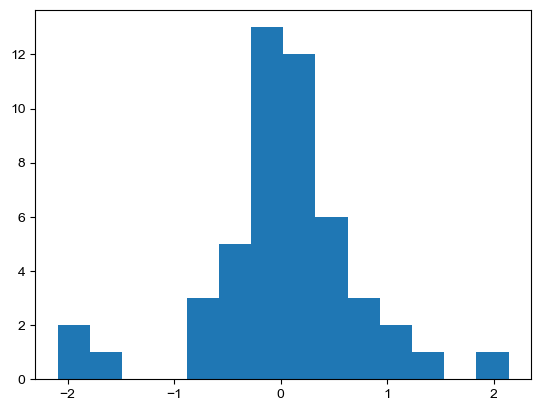

In [159]:
fig, ax = plt.subplots(dpi = 100)
if num_class == 2:
    _ = ax.hist(all_median_df[[1]], bins = "fd")
    print(all_median_df[[1]].min(), all_median_df[[1]].max())
elif num_class == 3:
    _ = ax.hist(all_median_df[[2]], bins = "fd")
    print(all_median_df[[2]].min(), all_median_df[[2]].max())